# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self, hidden_layers):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        hidden_layers.insert(0, 784)
        hidden_layers.append(10)
        self.linears = nn.ModuleList(
            [nn.Linear(i, j) for i, j in zip(hidden_layers[:-1], hidden_layers[1:])])

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i, layer in enumerate(self.linears):
            x = layer(x)
            # Use relu in all layers except last one
            if i != len(self.linears) - 1:
                x = F.relu(x)

        # Use softmax in last layer
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss # sum up batch loss
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return torch.tensor([train_loss, train_accuracy])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))

    return torch.tensor([test_loss, test_accuracy])


In [3]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 2e-3
use_cuda = True
seed = 1
log_interval = 10


use_cuda = use_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# Standard training without randomization

In [4]:
# Standard training for comparison
model = Net([128]).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
std_results = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer)
    res = test(model, device, test_loader)
    std_results.append(res)

Test set: Average loss: 0.1547, Accuracy: 9531/10000 (95%)

Test set: Average loss: 0.1060, Accuracy: 9680/10000 (97%)

Test set: Average loss: 0.0998, Accuracy: 9694/10000 (97%)

Test set: Average loss: 0.0837, Accuracy: 9732/10000 (97%)

Test set: Average loss: 0.0760, Accuracy: 9771/10000 (98%)



# Training models in setup 1: with randomized labels.

In [5]:
m = len(dataset1.targets) # number of examples
pixels_per_image = 784
n = 28 # pixels per row/column

X = [0.1, 0.5, 0.618, 0.7, 0.9, 0.95, 0.99]

def randomize_labels(dataset, labels_num):
    indices = torch.randperm(m)[:labels_num]
    new_labels = torch.multinomial(digit_dist, labels_num, replacement=True)
    dataset.targets[indices] = new_labels

# Use distribution of labels from training set
digit_dist = torch.bincount(dataset1.targets) / m
old_labels = torch.clone(dataset1.targets)
rand_labels_results = {'test': {x:[] for x in X}, 'training': {x:[] for x in X}}

for x in X:
    labels_num = int(m * x)
    randomize_labels(dataset1, labels_num)
    model = Net([128]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        res = train(model, device, train_loader, optimizer)
        rand_labels_results['training'][x].append(res)
        res = test(model, device, test_loader)
        rand_labels_results['test'][x].append(res)
    # Restore old labels
    dataset1.targets = torch.clone(old_labels)

Test set: Average loss: 0.2748, Accuracy: 9525/10000 (95%)

Test set: Average loss: 0.2255, Accuracy: 9611/10000 (96%)

Test set: Average loss: 0.2153, Accuracy: 9634/10000 (96%)

Test set: Average loss: 0.2026, Accuracy: 9686/10000 (97%)

Test set: Average loss: 0.2157, Accuracy: 9682/10000 (97%)

Test set: Average loss: 0.9219, Accuracy: 9195/10000 (92%)

Test set: Average loss: 0.7951, Accuracy: 9424/10000 (94%)

Test set: Average loss: 0.8392, Accuracy: 9403/10000 (94%)

Test set: Average loss: 0.7478, Accuracy: 9482/10000 (95%)

Test set: Average loss: 0.8121, Accuracy: 9506/10000 (95%)

Test set: Average loss: 1.0805, Accuracy: 9195/10000 (92%)

Test set: Average loss: 1.0106, Accuracy: 9341/10000 (93%)

Test set: Average loss: 1.0576, Accuracy: 9332/10000 (93%)

Test set: Average loss: 1.0967, Accuracy: 9315/10000 (93%)

Test set: Average loss: 1.0702, Accuracy: 9400/10000 (94%)

Test set: Average loss: 1.2748, Accuracy: 9086/10000 (91%)

Test set: Average loss: 1.2383, Accuracy

# Training models in setup 2: with randomized pixels.

In [6]:
X = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]

def randomize_pixels(dataset, pixels_num):
    for sample in dataset.data:
        indices = torch.randperm(pixels_per_image)[:pixels_num]
        new_pixels = torch.multinomial(pixel_dist, pixels_num, replacement=True).byte()
        sample.resize_(pixels_per_image)[indices] = new_pixels
        sample.resize_(n, n)

# Use distribution of pixels of images from training set
pixel_dist = torch.bincount(dataset1.data.resize(torch.prod(
    torch.as_tensor(dataset1.data.size())))) / (m * pixels_per_image)
old_samples = torch.clone(dataset1.data)
rand_pixels_results = {'test': {x:[] for x in X}, 'training': {x:[] for x in X}}

for x in X:
    pixels_num = int(pixels_per_image * x)
    model = Net([128]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        randomize_pixels(dataset1, pixels_num)
        res = train(model, device, train_loader, optimizer)
        rand_pixels_results['training'][x].append(res)
        res = test(model, device, test_loader)
        rand_pixels_results['test'][x].append(res)
        # Restore old pixel values
        dataset1.data = torch.clone(old_samples)

/home/michal/Dokumenty/3Year/GSN/venv/lib/python3.8/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Test set: Average loss: 0.1558, Accuracy: 9520/10000 (95%)

Test set: Average loss: 0.1060, Accuracy: 9680/10000 (97%)

Test set: Average loss: 0.0967, Accuracy: 9700/10000 (97%)

Test set: Average loss: 0.0875, Accuracy: 9732/10000 (97%)

Test set: Average loss: 0.0809, Accuracy: 9732/10000 (97%)

Test set: Average loss: 0.2689, Accuracy: 9287/10000 (93%)

Test set: Average loss: 0.1702, Accuracy: 9552/10000 (96%)

Test set: Average loss: 0.1634, Accuracy: 9571/10000 (96%)

Test set: Average loss: 0.1338, Accuracy: 9646/10000 (96%)

Test set: Average loss: 0.1242, Accuracy: 9683/10000 (97%)

Test set: Average loss: 0.4513, Accuracy: 8957/10000 (90%)

Test set: Average loss: 0.3184, Accuracy: 9238/10000 (92%)

Test set: Average loss: 0.2793, Accuracy: 9323/10000 (93%)

Test set: Average loss: 0.2479, Accuracy: 9408/10000 (94%)

Test set: Average loss: 0.2436, Accuracy: 9436/10000 (94%)

Test set: Average loss: 0.7135, Accuracy: 7833/10000 (78%)

Test set: Average loss: 0.6867, Accuracy

# Plots and report.

In [7]:
# Convert results to tensors to make slicing easier
std_results = torch.stack(std_results)
rand_labels_results = {k:{x:torch.stack(res) for x, res in v.items()} for k, v in rand_labels_results.items()}
rand_pixels_results = {k:{x:torch.stack(res) for x, res in v.items()} for k, v in rand_pixels_results.items()}

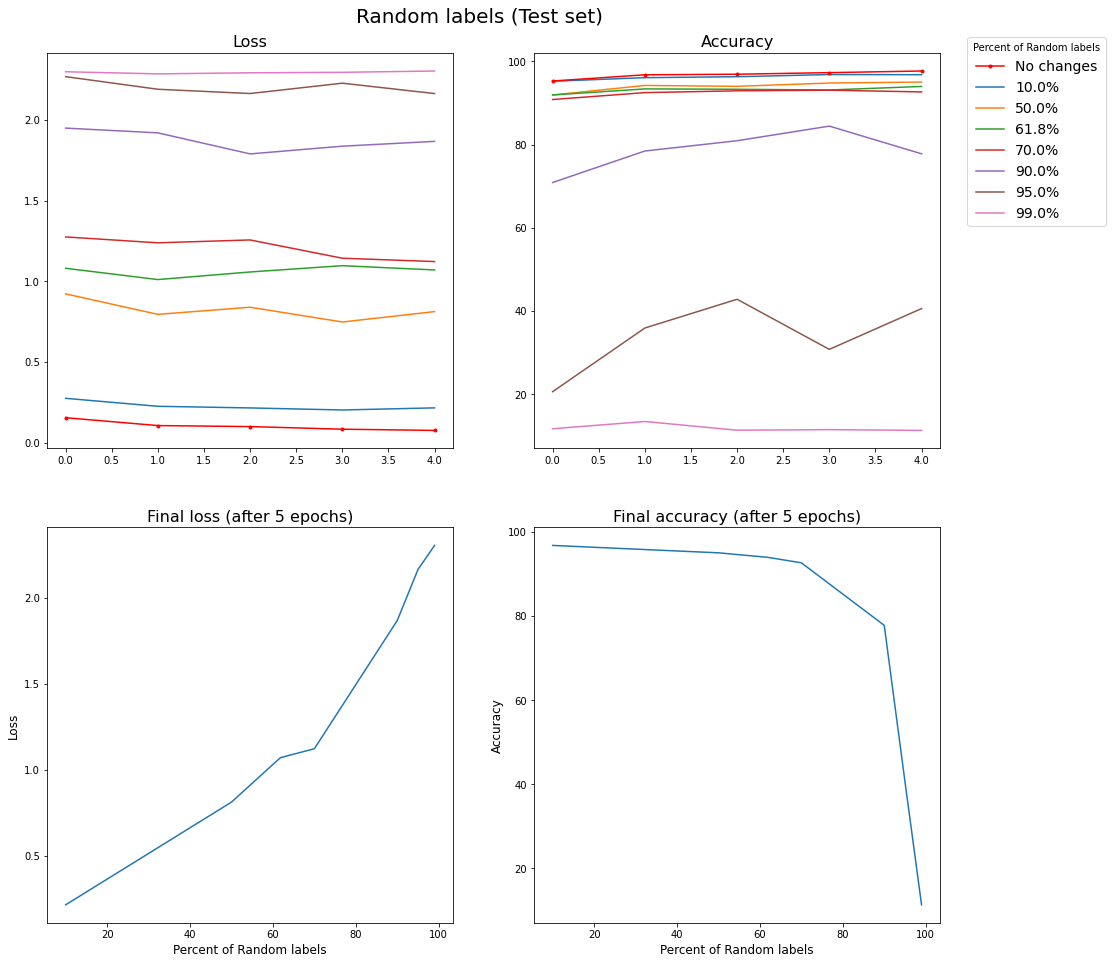

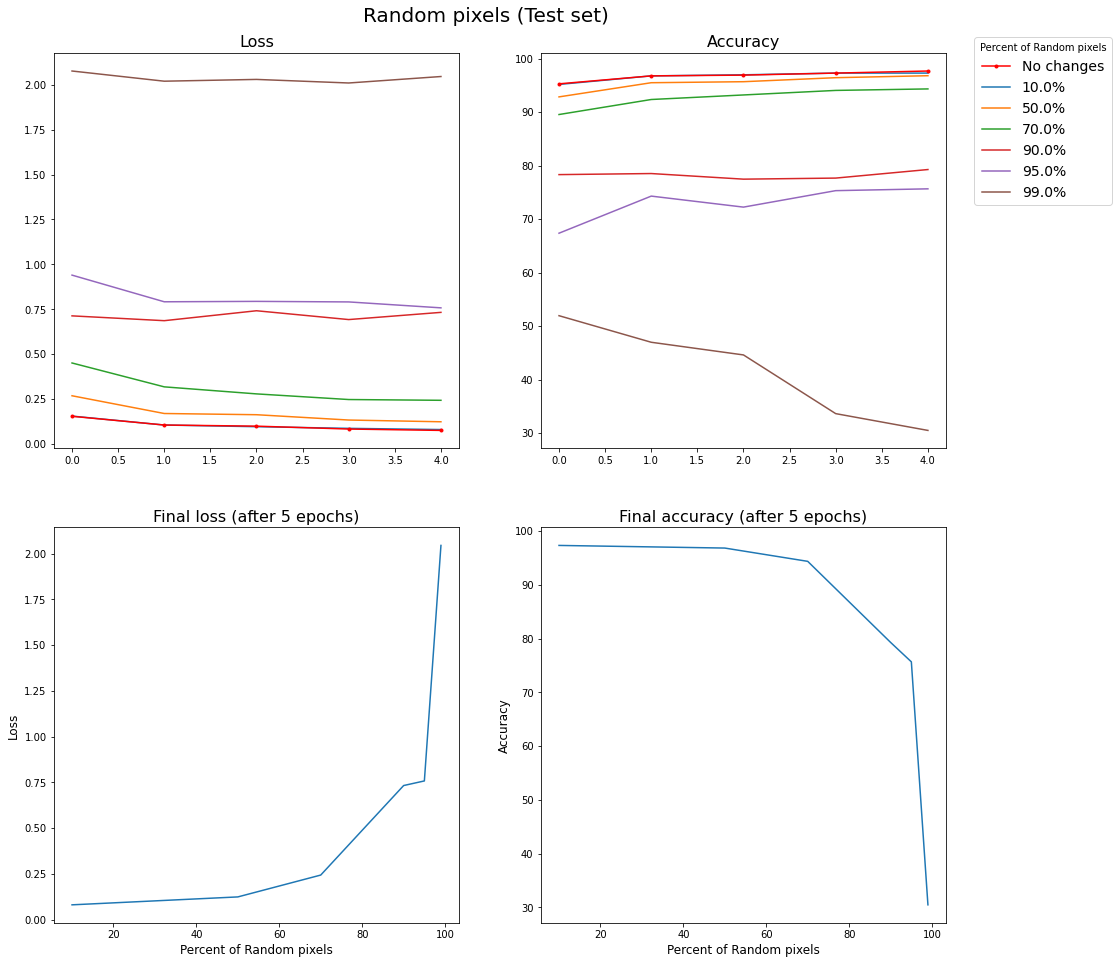

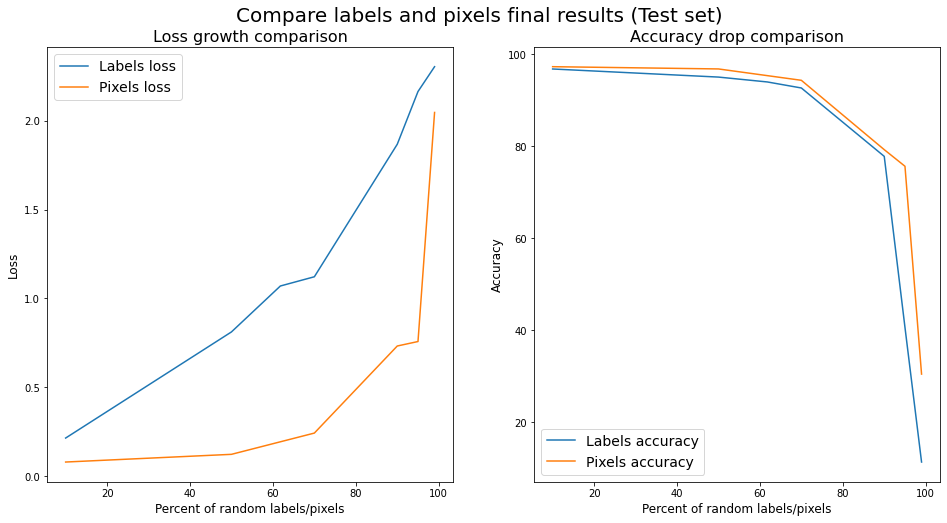

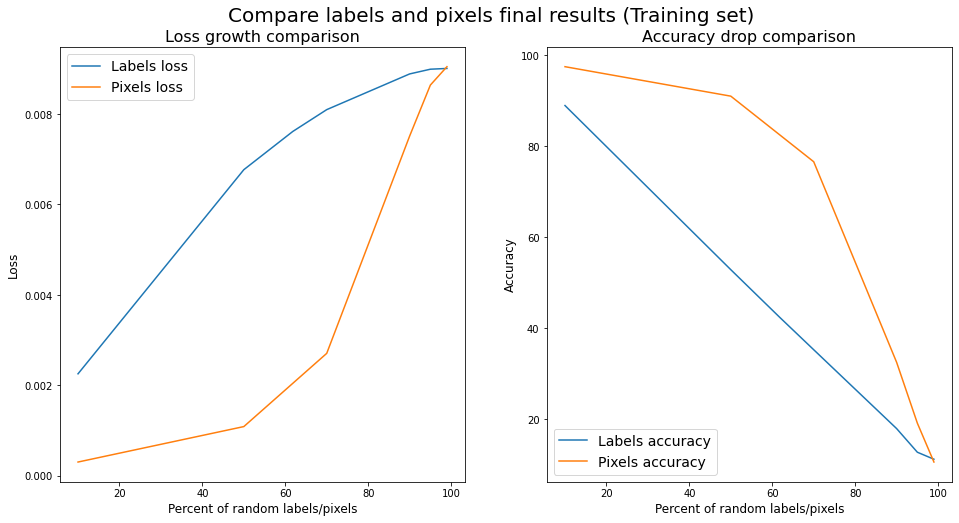

In [11]:
def plot_results(title, std_results, results):
    final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in results.items()])
    fig, ((loss, acc), (final_loss, final_acc)) = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(title + ' (Test set)', fontsize=20, y=0.92)
    loss.set_title('Loss', size=16)
    acc.set_title('Accuracy', size=16)
    final_loss.set_title('Final loss (after {} epochs)'.format(epochs), size=16)
    final_acc.set_title('Final accuracy (after {} epochs)'.format(epochs), size=16)

    loss.plot(std_results[:, 0], 'r.-', zorder=10, label='No changes')
    acc.plot(std_results[:, 1], 'r.-', zorder=10)

    for x, res in results.items():
        loss.plot(res[:, 0], label='{}%'.format(x * 100.))
        acc.plot(res[:, 1])

    fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9), prop={'size': 14}, title='Percent of {}'.format(title))

    final_loss.plot(final_values[:, 0], final_values[:, 1])
    final_loss.set_xlabel('Percent of {}'.format(title), fontsize=12)
    final_loss.set_ylabel('Loss', fontsize=12)
    final_acc.plot(final_values[:, 0], final_values[:, 2])
    final_acc.set_xlabel('Percent of {}'.format(title), fontsize=12)
    final_acc.set_ylabel('Accuracy', fontsize=12)

    plt.show()

def plot_comparison(rand_labels_results, rand_pixels_results, set_type):
    labels_final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in rand_labels_results.items()])
    pixels_final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in rand_pixels_results.items()])
    fig, (loss_comp, acc_comp) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Compare labels and pixels final results ({set_type} set)', fontsize=20, y=0.95)

    loss_comp.set_title('Loss growth comparison'.format(epochs), size=16)
    loss_comp.plot(labels_final_values[:, 0], labels_final_values[:, 1], label='Labels loss')
    loss_comp.plot(pixels_final_values[:, 0], pixels_final_values[:, 1], label='Pixels loss')
    loss_comp.set_xlabel('Percent of random labels/pixels', fontsize=12)
    loss_comp.set_ylabel('Loss', fontsize=12)
    loss_comp.legend(loc='upper left', prop={'size': 14})

    acc_comp.set_title('Accuracy drop comparison', size=16)
    acc_comp.plot(labels_final_values[:, 0], labels_final_values[:, 2], label='Labels accuracy')
    acc_comp.plot(pixels_final_values[:, 0], pixels_final_values[:, 2], label='Pixels accuracy')
    acc_comp.set_xlabel('Percent of random labels/pixels', fontsize=12)
    acc_comp.set_ylabel('Accuracy', fontsize=12)
    acc_comp.legend(loc='lower left', prop={'size': 14})

    plt.show()


# Random labels (test set)
plot_results('Random labels', std_results, rand_labels_results['test'])

# Random pixels (test set)
plot_results('Random pixels', std_results, rand_pixels_results['test'])

# Labels vs pixels (test set)
plot_comparison(rand_labels_results['test'], rand_pixels_results['test'], 'Test')

# Labels vs pixels (training set)
plot_comparison(rand_labels_results['training'], rand_pixels_results['training'], 'Training')

## Training set results analysis
For both labels and pixels, accuracy drops faster during training. In the same time log loss is way smaller in training (what is not surprising because model minimizes it during training and overfits to dataset).

## Test set results analysis
### Random labels
Loss seems to be raising nearly linearly.
Surprisingly, accuracy keeps being above 90% even when 70% of labels have been reassigned. Then it's slowly going down and starts rapidly falling at 90% random labels. Eventually, accuracy reaches 10-11% low (which is basically probability of randomly guessing digit on the picture) for 90% random labels.

### Random pixels
Loss is raising really slowly until 70% random pixels, then growth becomes faster and eventually skyrockets for more than 80% random pixels. Loss behaviour seems similar to exponential function.
Initially, accuracy behaves similarly as for random labels. Interesting is fact that, even for 99% pixels randomly changed, the accuracy is still much higher than 10% (between 30% and 40% depending on pixels sample) and in the same time loss raises exponentially (sometimes raises exponentially from 80% to 95% and then drops from 95% - it depends on pixels sample).

### Conclusions from both experiments
1. For random labels, even though loss raises steadily, the accuracy stays pretty high by most of the time. The reason is the way that accuracy works - it always selects digit with the highest final score. E.g. for 10% random labels, in final layer, we can get [0=0.01, 1=0.02, ..., k=0.89, ..., 9=0.02], whereas for 70% we may get [0=0.18, 1=0.09, ..., k=0.28, ..., 9=0.12]. In both situations digit k is selected.
It is because k will still get $1 - x - \epsilon$ score and other values, on average, will get $\sim(x / 9)$ score. It's clear that $1 - x = x / 9$ for $x = 0.9$ and that is also around that moment when accuracy on the chart is dropping rapidly. The reason why we have any drop of accuracy for $x < 0.9$ is probably uneven distribution of noise between batches.
2. Accuracy drops faster for random labels than pixels. But when we look on digit images from dataset it becomes clear what is happening. Distribution of pixels in the initial training set looks like this: most of the pixels are black, many pixels are white and there is very small number of pixels with color between black and white.
And we sample exactly from this distribution so most of the time we change black pixels to black pixels. Sometimes we introduce a bit of a white noise across the background and sometimes we change very small parts of digits to black.
In a result, pixel changes during training seem to be less significant for model test accuracy than label changes.
3. Accuracy way higher than 10% for 99% random pixels may also be result of above. Even when changing most of the pixels, sometimes the random pixels and remaining ones may still form certain pattern, allowing model to learn that pattern.
4. Why loss raises so fast for more than ~80% of random pixels? It is clear that loss will be high if model is totally incorrect (e.g. returns score ~0.9 for incorrect digit). That may be a reason in this case. Maybe model learns "antipatterns" and in the result gives high scores to completely wrong digits. (It seems that for many random pixels model gives high scores to one label, no matter if it is correct or not.)